# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os
from importlib import reload

In [2]:
reload(util)

print(util.get_gameweek_from_date("2025-1-4"))

20


In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

# Get the gameweek from the date
gameweek = util.get_gameweek_from_date(str(today.date()))
last_gameweek = gameweek - 1

gameweek
last_gameweek

19

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
try:
    with open('./hopsworks/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    print("In production mode")

project = hopsworks.login()
fs = project.get_feature_store()

2025-01-05 12:07:54,944 INFO: Initializing external client
2025-01-05 12:07:54,945 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-05 12:07:56,386 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
# Not used
# feature_view = fs.get_feature_view(
#     name='player_score_fv',
#     version=1,
# )

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="player_score_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.1982019E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Player Score Features From Previous Gameweek </span>



In [8]:
players_fg = fs.get_feature_group(
    name='player_features',
    version=1,
)
input_data = players_fg.filter(players_fg.gameweek == last_gameweek).read()
output_data = players_fg.filter(players_fg.gameweek == gameweek).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.89s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
inputs = ['prev_minutes', 'prev_goals_scored', 'prev_assists',
         'prev_clean_sheets', 'prev_goals_conceded', 'prev_own_goals',
         'prev_penalties_saved', 'prev_penalties_missed', 'prev_yellow_cards',
         'prev_red_cards', 'prev_saves', 'prev_bonus',
         'prev_bps', 'prev_influence', 'prev_creativity',
         'prev_threat', 'prev_ict_index', 'prev_starts',
         'prev_expected_goals', 'prev_expected_assists', 'prev_expected_goal_involvements',
         'prev_expected_goals_conceded', 'prev_in_dreamteam']

for i in range(0, len(input_data)):
    output_data.at[i, 'predicted_score'] = retrieved_xgboost_model.predict(input_data.loc[i, inputs].values.reshape(1, -1))[0]

output_data

,id,total_points,gameweek,prev_minutes,prev_goals_scored,prev_assists,prev_clean_sheets,prev_goals_conceded,prev_own_goals,prev_penalties_saved,...,prev_creativity,prev_threat,prev_ict_index,prev_starts,prev_expected_goals,prev_expected_assists,prev_expected_goal_involvements,prev_expected_goals_conceded,prev_in_dreamteam,predicted_score
0,253,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.503806
1,254,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2.536139
2,489,2,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.3,0.0,1.7,1.0,0.00,0.01,0.01,0.72,0.0,1.754258
3,252,9,20,67.0,1.0,0.0,0.0,1.0,0.0,0.0,...,4.0,48.0,9.6,1.0,0.36,0.00,0.36,1.52,0.0,0.214927
4,255,4,20,90.0,0.0,1.0,0.0,2.0,0.0,0.0,...,40.8,4.0,8.3,1.0,0.00,0.22,0.22,1.98,0.0,2.843832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,585,2,20,90.0,0.0,0.0,0.0,1.0,0.0,0.0,...,44.1,34.0,9.3,1.0,0.35,0.60,0.95,0.94,0.0,0.214927
705,543,1,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.8,17.0,3.2,1.0,0.14,0.01,0.15,2.25,0.0,NaN
706,564,1,20,90.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.7,1.0,1.6,1.0,0.02,0.00,0.02,2.25,0.0,NaN
707,192,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN


In [10]:
output_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               709 non-null    int64  
 1   total_points                     709 non-null    int64  
 2   gameweek                         709 non-null    int64  
 3   prev_minutes                     709 non-null    float64
 4   prev_goals_scored                709 non-null    float64
 5   prev_assists                     709 non-null    float64
 6   prev_clean_sheets                709 non-null    float64
 7   prev_goals_conceded              709 non-null    float64
 8   prev_own_goals                   709 non-null    float64
 9   prev_penalties_saved             709 non-null    float64
 10  prev_penalties_missed            709 non-null    float64
 11  prev_yellow_cards                709 non-null    float64
 12  prev_red_cards        

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-01-05 12:08:04,125 WARNING: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.



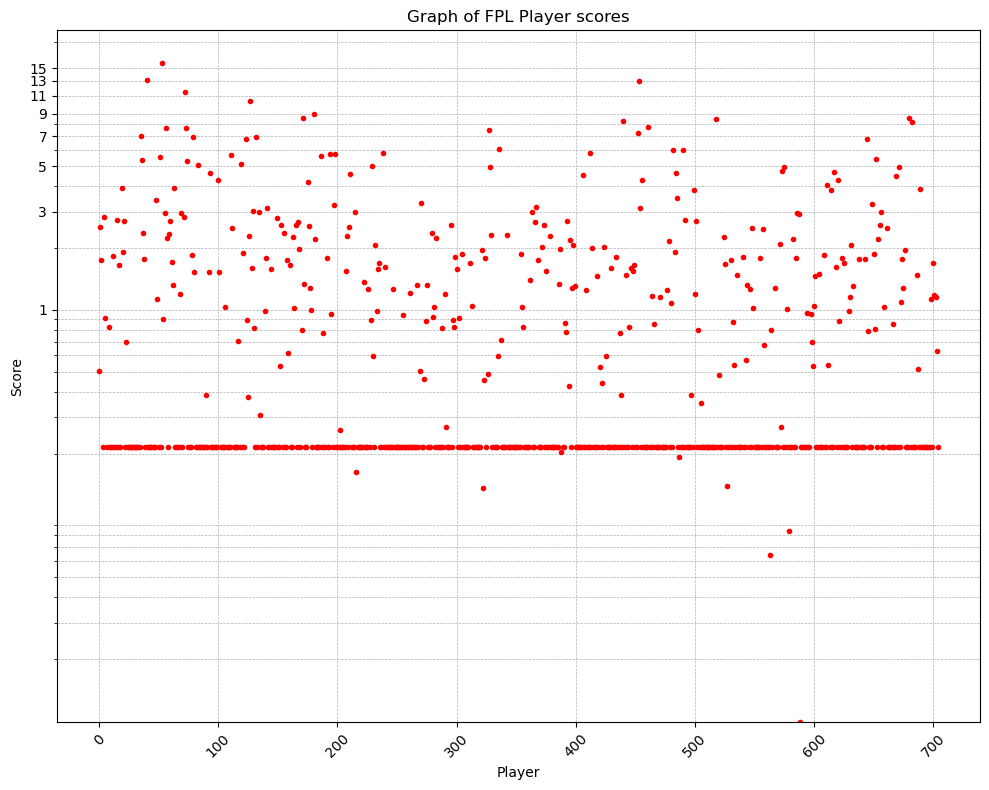

In [11]:
file_path = "./player_score_model/images/predicted_scores.png"
plt = util.plot_player_score_forecast("FPL Player scores", output_data, file_path, hindcast=False)
plt.show()

In [12]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='fpl_predictions',
    description='FPL player score prediction monitoring',
    version=1,
    primary_key=['id', 'gameweek']
)

In [13]:
monitor_fg.insert(output_data, write_options={"wait_for_job": True})

FeatureStoreException: Features are not compatible with Feature Group schema: 
 - prev_influence (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_creativity (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_threat (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_ict_index (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_expected_goals (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_expected_assists (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_expected_goal_involvements (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_expected_goals_conceded (expected type: 'string', derived from input: 'double') has the wrong type.
 - prev_in_dreamteam (expected type: 'boolean', derived from input: 'double') has the wrong type.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

In [42]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
# monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
# monitoring_df

In [43]:
# air_quality_fg = fs.get_feature_group(
#     name='air_quality',
#     version=1,
# )
# air_quality_df = air_quality_fg.read()
# air_quality_df

In [44]:
# from functions.util import backfill_predictions_for_monitoring

# outcome_df = air_quality_df[['date', 'pm25']]
# preds_df =  monitoring_df[['date', 'predicted_pm25']]

# hindcast_df = pd.merge(preds_df, outcome_df, on="date")
# hindcast_df = hindcast_df.sort_values(by=['date'], ascending=False)

# # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
# if len(hindcast_df) == 0:
#     hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, today)
# hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [45]:
# file_path = "../../docs/assets/images/pm25_hindcast.png"
# plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
# plt.show()

---